<a href="https://colab.research.google.com/github/MithunKiniStar/AutoEncodersFaceSketch/blob/main/Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras==2.2.4
!pip install tensorflow==1.13.1

     |████████████████████████████████| 312 kB 8.5 MB/s 
     |████████████████████████████████| 50 kB 3.5 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires keras<2.9,>=2.8.0rc0, but you have keras 2.2.4 which is incompatible.
     |████████████████████████████████| 92.6 MB 1.2 MB/s 
     |████████████████████████████████| 367 kB 72.1 MB/s 
     |████████████████████████████████| 3.2 MB 53.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator

In [ ]:
import numpy as np
import tensorflow as tf
import keras 
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
import os
import re 
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


# defining the size of image 
SIZE = 64

image_path = '/content/photos'
img_array = []

sketch_path = '/content/sketches'
sketch_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
sketch_file = sorted_alphanumeric(os.listdir(sketch_path))


for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i,1)
    print("Image is ",image)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    
    #appending normal normal image    
    img_array.append(img_to_array(image))
    # Image Augmentation
    
    # horizontal flip 
    img1 = cv2.flip(image,1)
    img_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    img_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    img_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    img_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    img_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    img_array.append(img_to_array(img7))
  
    
for i in tqdm(sketch_file):
    image = cv2.imread(sketch_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    # appending normal sketch image
    sketch_array.append(img_to_array(image))
    
    #Image Augmentation
    # horizontal flip 
    img1 = cv2.flip(image,1)
    sketch_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    sketch_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    sketch_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    sketch_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    sketch_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    sketch_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    sketch_array.append(img_to_array(img7))

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten
from tensorflow.keras.layers import Reshape, BatchNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import TensorBoard

# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sample_z(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    mu, sigma = args
    batch     = K.shape(mu)[0]
    dim       = K.int_shape(mu)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    eps       = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps

In [4]:
image_width  = 64
image_height = 64
latent_dim   = 2
no_epochs    = 30
batch_size   = 128
num_channels = 3

In [5]:

# Defining the encoder
inputs = Input(shape=(image_width, image_height, 3), name='encoder_input')  

x = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = BatchNormalization()(x)
conv_shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(16)(x)
x = BatchNormalization()(x)
mu = Dense(latent_dim, name='latent_mu')(x)
sigma = Dense(latent_dim, name='latent_sigma')(x)

# use reparameterization trick to push the sampling out as input
z  = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])


encoder = Model(inputs, [mu, sigma, z], name='encoder')
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   18496       batch_normalization_v1[0][0]     
_____________________________________

In [ ]:
conv_shape

(None, 16, 16, 64)

In [6]:
# Defining decoder
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(8, (3, 3), strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(cx)

# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             49152     
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 16384)             65536     
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 16)        9232      
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 64, 64, 8)         1160      
__________

In [7]:
# Build VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 64, 64, 3)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 282068    
_________________________________________________________________
decoder (Model)              (None, 64, 64, 3)         125395    
Total params: 407,463
Trainable params: 374,423
Non-trainable params: 33,040
_________________________________________________________________


In [8]:
def vae_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * image_width * image_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

In [9]:
print("Total number of sketch images:",len(sketch_array))
print("Total number of images:",len(img_array))
train_sketch_image = sketch_array[:1400]
train_image = img_array[:1400]
test_sketch_image = sketch_array[1400:]
test_image = img_array[1400:]
# reshaping
train_sketch_image = np.reshape(train_sketch_image,(len(train_sketch_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
print('Train color image shape:',train_image.shape)
test_sketch_image = np.reshape(test_sketch_image,(len(test_sketch_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test color image shape',test_image.shape)

Total number of sketch images: 1504
Total number of images: 1504
Train color image shape: (1400, 64, 64, 3)
Test color image shape (104, 64, 64, 3)


**Modelling for Face To Sketch**

Train on 1400 samples, validate on 104 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1400/1400 [==============================] - 20s 14ms/sample - loss: 2865.6308 - val_loss: 2712.3853
Epoch 2/100
1400/1400 [==============================] - 19s 13ms/sample - loss: 2488.0360 - val_loss: 2577.8953
Epoch 3/100
1400/1400 [==============================] - 19s 13ms/sample - loss: 2299.1210 - val_loss: 2408.2377
Epoch 4/100
1400/1400 [==============================] - 19s 13ms/sample - loss: 2124.5674 - val_loss: 2245.4120
Epoch 5/100
1400/1400 [==============================] - 19s 13ms/sample - loss: 1959.0532 - val_loss: 2083.9574
Epoch 6/100
1400/1400 [==============================] - 19s 13ms/sample - loss: 1821.2385 - val_loss: 1983.1844
Epoch 7/100
1400/1400 [==============================] - 19s 13ms/sample - loss: 1723.6854 - val_loss: 1930.3525
Epoch 8/100
1400/1400 [==============================] - 19s 13ms/sample - loss: 1657.7162 - val_loss: 1918.3303
E

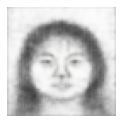

In [10]:
# vae.compile(optimizer='adam', loss=vae_loss)
vae.compile(optimizer='rmsprop', loss= vae_loss)
encoder.compile(optimizer = 'rmsprop', loss = vae_loss)
decoder.compile(optimizer = 'rmsprop', loss = vae_loss)
vae.fit(train_image, train_sketch_image,
        epochs=100,
        batch_size=80,
        validation_data=(test_image, test_sketch_image))

# Randomly sample one or more charachters and plot them
random_chars = [np.random.normal(0, 1, latent_dim) for _ in range(1)]
imgs = []
for char in random_chars:
    char = char.reshape(-1,2)
    imgs.append(decoder.predict(char))

imgs = [np.reshape(img,(image_width, image_height, 3)) for img in imgs]
for img in imgs:
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

(2,)


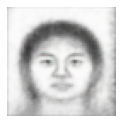

In [43]:
# Randomly sample one or more charachters and plot them
random_chars = [np.random.normal(0, 1, latent_dim) for _ in range(1)]
imgs = []
for char in random_chars:
    char = char.reshape(-1,2)
    imgs.append(decoder.predict(char))

print(random_chars[0].shape)
imgs = [np.reshape(img,(image_width, image_height, 3)) for img in imgs]
for img in imgs:
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

# plt.imshow(test_image[0].reshape(256, 256, 3))

In [ ]:
random_chars

[array([ 0.46834664, -0.92630004])]

In [49]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import structural_similarity as ssim
decoded_imgs = img
print("SSIM value is ",ssim(train_sketch_image[1].reshape(64, 64, 3), decoded_imgs, multichannel = True))

SSIM value is  0.6072100187582243


**Modelling for Sketch To Face**

Train on 1400 samples, validate on 104 samples
Epoch 1/100
1400/1400 [==============================] - 22s 15ms/sample - loss: 3179.3527 - val_loss: 2728.7471
Epoch 2/100
1400/1400 [==============================] - 19s 14ms/sample - loss: 2816.3421 - val_loss: 2499.4242
Epoch 3/100
1400/1400 [==============================] - 20s 14ms/sample - loss: 2642.7213 - val_loss: 2414.2703
Epoch 4/100
1400/1400 [==============================] - 19s 14ms/sample - loss: 2534.3347 - val_loss: 2359.1201
Epoch 5/100
1400/1400 [==============================] - 19s 14ms/sample - loss: 2466.0138 - val_loss: 2351.5602
Epoch 6/100
1400/1400 [==============================] - 19s 14ms/sample - loss: 2414.4000 - val_loss: 2312.0188
Epoch 7/100
1400/1400 [==============================] - 19s 14ms/sample - loss: 2364.9218 - val_loss: 2275.3839
Epoch 8/100
1400/1400 [==============================] - 20s 14ms/sample - loss: 2331.4414 - val_loss: 2259.3258
Epoch 9/100
1400/1400 [==========================

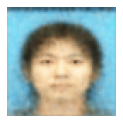

In [ ]:
# vae.compile(optimizer='adam', loss=vae_loss)
vae.compile(optimizer='rmsprop', loss= vae_loss)
encoder.compile(optimizer = 'rmsprop', loss = vae_loss)
decoder.compile(optimizer = 'rmsprop', loss = vae_loss)
vae.fit(train_sketch_image, train_image,
        epochs=100,
        batch_size=80,
        validation_data=(test_sketch_image, test_image))

random_chars = [np.random.normal(0, 1, latent_dim) for _ in range(1)]
imgs = []
for char in random_chars:
    char = char.reshape(-1,2)
    imgs.append(decoder.predict(char))

imgs = [np.reshape(img,(image_width, image_height, 3)) for img in imgs]
for img in imgs:
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

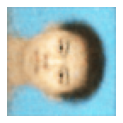

In [ ]:
random_chars = [np.random.normal(0, 1, latent_dim) for _ in range(1)]
imgs = []
for char in random_chars:
    char = char.reshape(-1,2)
    imgs.append(decoder.predict(char))

imgs = [np.reshape(img,(image_width, image_height, 3)) for img in imgs]
for img in imgs:
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

**Hyperparameter Tuning**

In [ ]:
def encoder(hp):
  inputs = Input(shape=(image_width, image_height, 3), name='encoder_input')  

  x = Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
             kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
             activation='relu',
             strides=2, padding='same')(inputs)
  
  x = BatchNormalization()(x)

  x = Conv2D(filters=hp.Int('conv_2_filter', min_value=64, max_value=128, step=16),
             kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
             activation='relu',
             strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  conv_shape = K.int_shape(x)
  x = Flatten()(x)
  x = Dense(16)(x)
  x = BatchNormalization()(x)
  mu = Dense(latent_dim, name='latent_mu')(x)
  sigma = Dense(latent_dim, name='latent_sigma')(x)

  # use reparameterization trick to push the sampling out as input
  z  = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])


  encoder = Model(inputs, [mu, sigma, z], name='encoder')
  encoder.summary()
  
  # Defining decoder
  d_i   = Input(shape=(latent_dim, ), name='decoder_input')
  x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
  x     = BatchNormalization()(x)
  x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
  cx    = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu')(x)
  cx    = BatchNormalization()(cx)
  cx    = Conv2DTranspose(8, (3, 3), strides=2, padding='same',  activation='relu')(cx)
  cx    = BatchNormalization()(cx)
  o     = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(cx)

  # Instantiate decoder
  decoder = Model(d_i, o, name='decoder')
  decoder.summary()

  # Build VAE model
  outputs = decoder(encoder(inputs)[2])
  vae = Model(inputs, outputs, name='vae')
  vae.summary()

  vae.compile(optimizer='adam', loss=vae_loss)
  return vae


In [ ]:
tuner_search=RandomSearch(build_model,
                          objective='val_acc',
                          max_trials=5,directory='/content/output3',project_name="FaceToSketch")


In [ ]:
tuner_search.search(train_sketch_image,train_image,epochs=500,validation_split=0.1, validation_data=(test_sketch_image, test_image))

In [ ]:
model=tuner_search.get_best_models(num_models=1)[0]
model.summary()

In [ ]:
random_chars = [np.random.normal(0, 1, latent_dim) for _ in range(1)]
imgs = []
for char in random_chars:
    char = char.reshape(-1,2)
    imgs.append(model.predict(char))

imgs = [np.reshape(img,(image_width, image_height, 3)) for img in imgs]
for img in imgs:
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(img, cmap='gray')